In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns
from scipy import stats
import laplacejumps as lj
import itertools
import statsmodels.api as sm
from pandas_datareader import data as pd_data

In [2]:
paper = False

In [3]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')

if paper:
    presentation_fontsize = 16
else:
    presentation_fontsize = 22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [4]:
# pgf_with_custom_preamble = {
#     "font.family": "serif", # use serif/main font for text elements
#     "text.usetex": True,    # use inline math for ticks
#     "pgf.rcfonts": False,   # don't setup fonts from rc parameters
#     "pgf.preamble": [
#          r"\usepackage{unicode-math}",  # unicode math setup
#          r'\usepackage{xcolor}'     
#          ]
# }

In [5]:
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
# mpl.rcParams.update(pgf_with_custom_preamble)

## Load the data

In [6]:
with pd.HDFStore('../results/spy_local_estimates_2003-2017_1000_1sec.hdf') as volatility_store:
    local_vol = volatility_store['local_vol_est']
    preaveraged_data = volatility_store['preaveraged_data']

In [7]:
with pd.HDFStore('../results/spy_daily_estimates_2003-2017_1000_1sec.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est']
    bipower_vol = volatility_store['bipower_vol']

In [8]:
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['jump_prop'] = discrete_vol['jumps'] / discrete_vol['quad']
log_vol = discrete_vol.transform(np.log)

In [9]:
daily_rtn_data = pd.read_csv('../results/spy_daily_rtn_2003-2017_with_overnight.csv', index_col=0,
                         parse_dates=True).rename(columns={'log_price':'daily_rtn'}).daily_rtn
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})
daily_rtn = (daily_rtn_data - treasury_yield.T).T.rename(columns={'log_yield':'daily_rtn'}).dropna()

In [10]:
fed_announcement_dates = pd.read_hdf('../results/fomc_times.hdf', 'table')
dates = pd.DataFrame(np.ones((fed_announcement_dates.size,1)), 
                     index=fed_announcement_dates['FOMC_times']).resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})

In [11]:
discrete_vol['daily_rtn'] = daily_rtn
log_vol['daily_rtn'] = daily_rtn
discrete_vol['fomc'] = dates
log_vol['fomc'] = dates
discrete_vol.dropna(inplace=True)
log_vol.dropna(inplace=True)

## Setup hyperparamters

In [12]:
percentiles = np.asarray([50, 90, 99])

## Examine Summary Stats

In [ ]:
daily_rtn.var() / discrete_vol.mean().quad

In [ ]:
daily_rtn.head()

In [ ]:
discrete_vol.head()

### Discrete Volatility Parameters

In [ ]:
discrete_vol.describe()

In [ ]:
discrete_vol.skew()

In [ ]:
discrete_vol.kurtosis() + 3

In [ ]:
discrete_vol.corr()

In [ ]:
discrete_vol.diff().corr()

### Log Volatilty Parameters

In [ ]:
log_vol.describe()

In [ ]:
log_vol.skew()

In [ ]:
log_vol.kurtosis() +3

In [ ]:
log_vol.corr()

In [ ]:
discrete_vol.head()

In [ ]:
discrete_vol.loc['2008-08-25']

In [ ]:
discrete_vol.loc['2008-07':'2008-12'].quad.count()

In [ ]:
np.sum(discrete_vol.quad < 7.8182e-05) / discrete_vol.quad.count()

In [ ]:
np.sum(discrete_vol.loc['2008-07':'2008-12'].quad < 7.8182e-05) / 128

In [ ]:
np.mean(discrete_vol.loc['2008-07':'2008-12'].quad < 7.8182e-05)

In [ ]:
log_vol.diff().corr()

## Density Plot

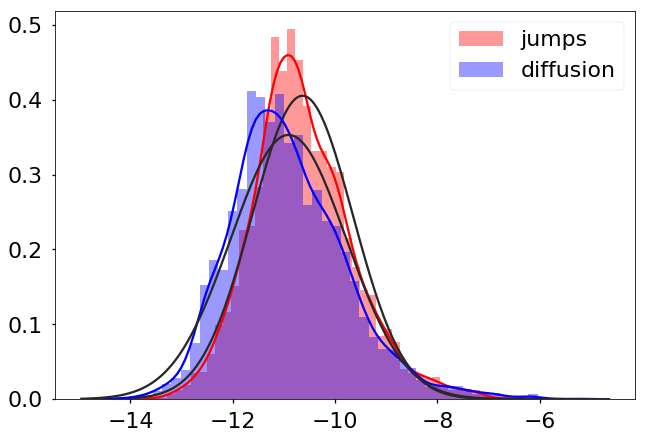

In [13]:
log_vol_dist_comp_fig, log_vol_dist_comp_ax = mpl.pyplot.subplots()
sns.distplot(log_vol['jumps'].dropna(), label='jumps', ax=log_vol_dist_comp_ax, color='red',
             fit=stats.norm)
sns.distplot(log_vol['diffusion'].dropna(), label='diffusion', ax=log_vol_dist_comp_ax, color='blue',
             fit=stats.norm)
log_vol_dist_comp_ax.legend()
log_vol_dist_comp_ax.set_xlabel("")
log_vol_dist_comp_fig.savefig('../doc/figures/log_vol_distributions.tmp.pdf', bbox_tight=True,
                              transparent=True)

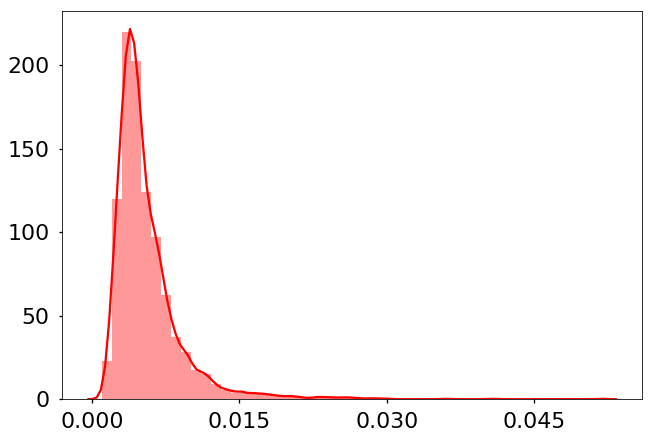

In [14]:
jump_vol_dens_fig, jump_vol_dens_ax = mpl.pyplot.subplots()
sns.distplot(discrete_vol['jumps'].apply(np.sqrt).dropna(), ax=jump_vol_dens_ax, color='red', 
             kde=True, bins=np.sort(np.geomspace(start=1.04, stop=1, num=40) - 1))
# jump_vol_dens_ax.set_xlim([0, 0.03])
# jump_vol_dens_ax.set_ylim([0, 175])
jump_vol_dens_ax.set_xlabel("")
jump_vol_dens_ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
jump_vol_dens_fig.savefig('../doc/figures/jump_vol_distribution.tmp.pdf', bbox_tight=True, transparent=True)

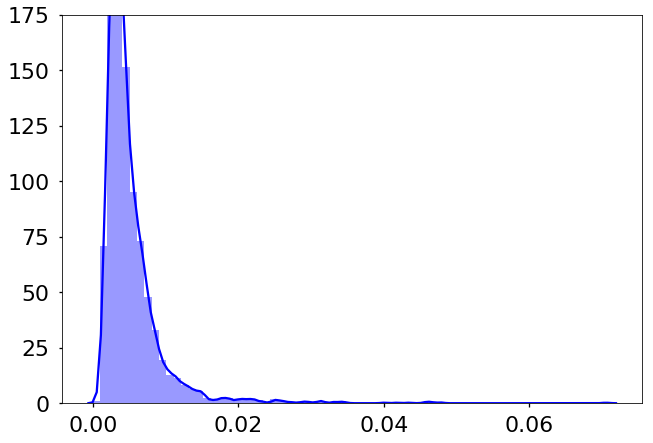

In [15]:
diffusion_vol_dens_fig, diffusion_vol_dens_ax = mpl.pyplot.subplots()
sns.distplot(discrete_vol['diffusion'].apply(np.sqrt).dropna(), ax=diffusion_vol_dens_ax, color='blue', 
             kde=True, bins=np.sort(np.geomspace(start=1.04, stop=1, num=40) - 1))
# diffusion_vol_dens_ax.set_xlim([0, 0.03])
diffusion_vol_dens_ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
diffusion_vol_dens_ax.set_ylim([0, 175])
diffusion_vol_dens_ax.set_xlabel("")
diffusion_vol_dens_fig.savefig('../doc/figures/diffusion_vol_distribution.tmp.pdf', bbox_tight=True, transparent=True)

## Volatilty Estimates over Time

/home/sangrey/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6070: RuntimeWarning: invalid value encountered in sqrt
  return lib.map_infer(x.astype(object).values, func)


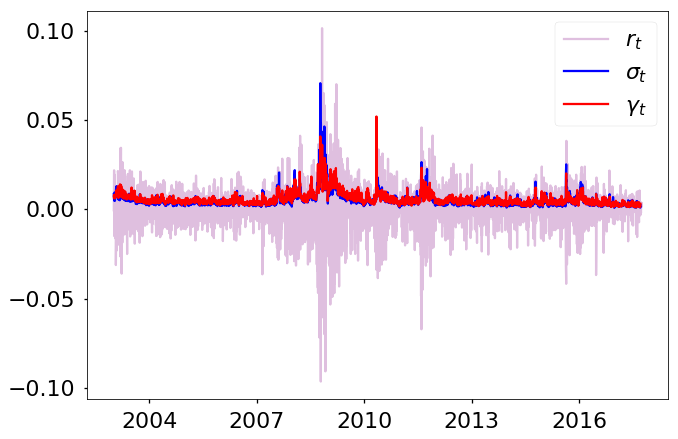

In [16]:
root_vol = discrete_vol.dropna().applymap(np.sqrt)
discrete_vol_fig = mpl.pyplot.figure()
discrete_vol_ax = discrete_vol_fig.add_subplot(111)
discrete_vol_ax.plot(daily_rtn.index.to_pydatetime(), daily_rtn, label='$r_t$', color='purple', alpha=.25)
discrete_vol_ax.plot(root_vol.index.to_pydatetime(), root_vol.diffusion, label='$\sigma_t$',
                     color='blue')
discrete_vol_ax.plot(root_vol.index.to_pydatetime(), root_vol.jumps, label='$\gamma_t$', color='red')
discrete_vol_ax.set_xlabel("")
discrete_vol_ax.xaxis.set_major_locator(mpl.dates.YearLocator(3))
discrete_vol_ax.legend()
discrete_vol_ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
# discrete_vol_ax.set_ylim([-.02, 0.02])
if paper:
    discrete_vol_fig.savefig('../doc/figures/volatilities_paper.tmp.pdf', bbox_tight=True, transparent=True,
                        pad_inches=0, frameon=False)
else: 
    discrete_vol_fig.savefig('../doc/figures/volatilities_present.tmp.pdf', bbox_tight=True, transparent=True,
                        pad_inches=0, frameon=False)

## Densities of the Log Volatility

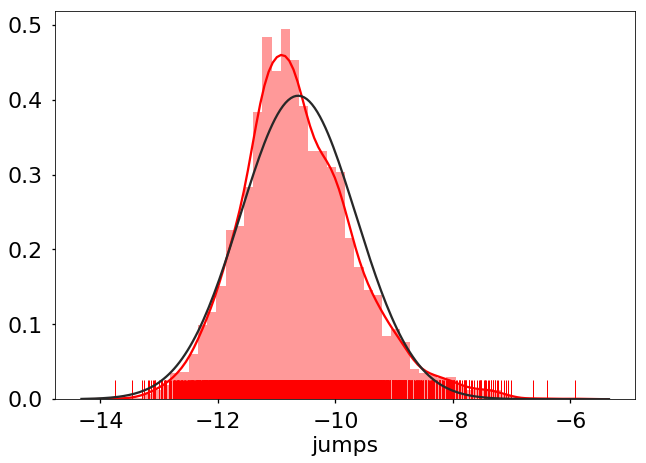

In [17]:
log_jump_vol_fig, log_jump_vol_ax = mpl.pyplot.subplots()
sns.distplot(log_vol['jumps'].dropna(), rug=True, fit=stats.norm, ax=log_jump_vol_ax, color='red')

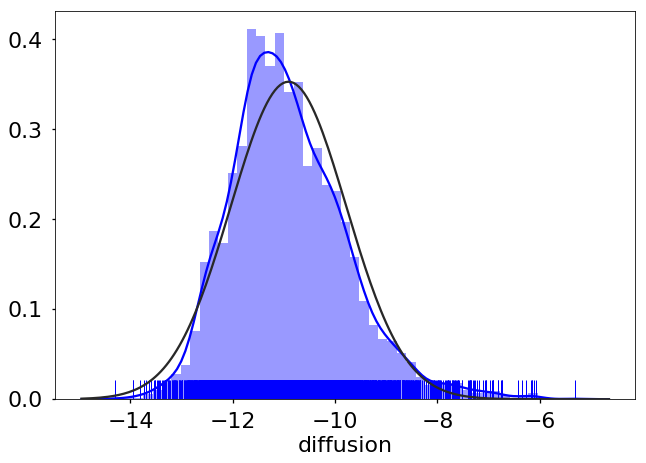

In [18]:
sns.distplot(log_vol['diffusion'].dropna(), rug=True, fit=stats.norm, color='blue')

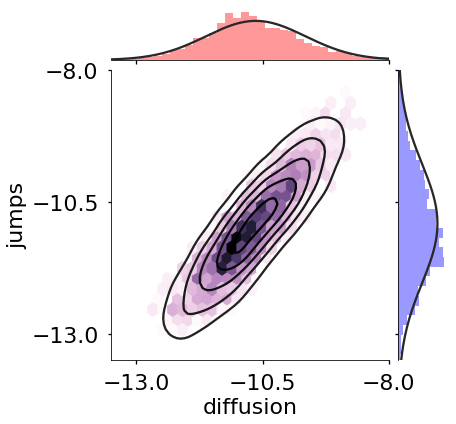

In [20]:
log_vol_dist = sns.JointGrid(x='jumps', y='diffusion', data=log_vol)
sns.distplot(log_vol['diffusion'].dropna().values, vertical=True, color='blue', fit=stats.norm, kde=False, 
             ax=log_vol_dist.ax_marg_y,)
sns.distplot(log_vol['jumps'].dropna().values, vertical=False, color='red', fit=stats.norm, kde=False, 
             ax=log_vol_dist.ax_marg_x)
log_vol_dist.ax_marg_x.set_xlim([-13.5, -8])
log_vol_dist.ax_marg_y.set_ylim([-13.5, -8])
log_vol_dist.ax_marg_x.xaxis.set_major_locator(mpl.ticker.FixedLocator([-13, -10.5, -8]))
log_vol_dist.ax_marg_y.yaxis.set_major_locator(mpl.ticker.FixedLocator([-13, -10.5, -8]))

data = pd.DataFrame(stats.multivariate_normal.rvs(size=log_vol['jumps'].count(), 
                                                  mean=log_vol[['jumps', 'diffusion']].mean(), 
                                                  cov=log_vol[['jumps', 'diffusion']].cov())).rename(
                    columns={0:'diffusion', 1:'jumps'})
sns.kdeplot(data=data['diffusion'].dropna(), data2=data['jumps'].dropna(), ax=log_vol_dist.ax_joint, 
            n_levels=5, zorder=10, cmap=sns.dark_palette('black', as_cmap=True))
log_vol_dist.ax_joint.hexbin(x=log_vol['jumps'].dropna(), y=log_vol['diffusion'].dropna(), 
                             gridsize=40, mincnt=4, cmap=sns.cubehelix_palette(1, as_cmap=True, start=0,
                                                                               rot=.2, dark=0, light=1))

# log_vol_dist.ax_joint.set_xlabel(r'$\log(\textcolor{red}{\gamma^2_t})$')
# log_vol_dist.ax_joint.set_ylabel(r'$\log(\textcolor{blue}{\sigma^2_t})$')

if paper:
    filename = '../doc/figures/log_vol_distributions.tmp.pdf'
else:
    filename = '../doc/figures/log_vol_distributions_present.tmp.pdf'
    
log_vol_dist.savefig(filename, bbox_tight=True, transparent=True, pad_inches=0, frameon=False)

## Volatility Estimator Comparison

In [ ]:
jump_vol_comp_fig, jump_vol_comp_ax = mpl.pyplot.subplots()
jump_vol_comp_ax.plot(discrete_vol['jumps'].apply(np.sqrt).dropna(), label='Proposed', color='red')
jump_vol_comp_ax.plot(bipower_vol['jumps'].apply(np.sqrt).dropna(), label='Bipower', color='orange')
jump_vol_comp_ax.legend()
jump_vol_comp_ax.set_xlabel("Jumps")


In [ ]:
diffusion_vol_comp_fig, diffusion_vol_comp_ax = mpl.pyplot.subplots()
diffusion_vol_comp_ax.plot(bipower_vol['diffusion'].apply(np.sqrt).dropna(),
                           label='Bipower')
diffusion_vol_comp_ax.plot(discrete_vol['diffusion'].apply(np.sqrt).dropna(), label='Proposed')
diffusion_vol_comp_ax.set_xlabel('Diffusion')
diffusion_vol_comp_ax.legend()
